# Fingerprint Minutiae Detection and Matching
## CIS 663 - Biometrics Course
### Syracuse University - Dr. Greg Wagner

This notebook demonstrates fingerprint minutiae detection and matching techniques. We'll cover:
1. Fingerprint preprocessing (binarization, thinning)
2. Minutiae extraction using crossing numbers
3. Minutiae classification (termination vs. bifurcation)
4. Two matching techniques: minutiae-based and local matching
5. Performance evaluation with ROC curves
6. Threshold analysis and its impact on performance

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage, signal
from scipy.ndimage import gaussian_filter
from skimage import exposure, filters, morphology, measure
from skimage.morphology import skeletonize, thin
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 1. Dataset Setup and Utility Functions

We'll use the same synthetic fingerprint dataset and add utilities for minutiae detection.

In [2]:
def create_synthetic_fingerprints():
    """Create synthetic fingerprint patterns for demonstration"""
    fingerprints = []
    labels = []
    
    # Create different fingerprint patterns with more detailed ridge structures
    for pattern_type in ['arch', 'loop', 'whorl']:
        for i in range(10):  # 10 samples per type
            img = np.zeros((256, 256))
            
            if pattern_type == 'arch':
                # Create arch pattern with parallel ridges
                y, x = np.ogrid[:256, :256]
                center_y, center_x = 128, 128
                for r in range(10, 150, 6):
                    # Create curved ridges
                    curve = center_y + 30 * np.sin((x - center_x) / 40)
                    mask = (np.abs(y - curve - r) < 2)
                    img[mask] = 1
                    
            elif pattern_type == 'loop':
                # Create loop pattern with more realistic ridge flow
                y, x = np.ogrid[:256, :256]
                center_y, center_x = 128, 128
                theta = np.arctan2(y - center_y, x - center_x)
                r = np.sqrt((x - center_x)**2 + (y - center_y)**2)
                
                # Create spiral ridges
                for ridge in range(5, 25, 2):
                    spiral = (r + ridge * np.sin(2 * theta)) % 8 < 1.5
                    img[spiral & (r < 100) & (r > ridge)] = 1
                    
            else:  # whorl
                # Create whorl pattern with concentric circles
                y, x = np.ogrid[:256, :256]
                center_y, center_x = 128, 128
                theta = np.arctan2(y - center_y, x - center_x)
                r = np.sqrt((x - center_x)**2 + (y - center_y)**2)
                
                # Create circular ridges with some variation
                for ridge in range(20, 120, 8):
                    circle = np.abs(r - ridge - 3*np.sin(4*theta)) < 2
                    img[circle] = 1
            
            # Add realistic noise and smooth
            img = gaussian_filter(img, sigma=0.8)
            img += 0.05 * np.random.random((256, 256))
            img = np.clip(img, 0, 1)
            
            fingerprints.append((img * 255).astype(np.uint8))
            labels.append(pattern_type)
    
    return fingerprints, labels

# Load fingerprint dataset
print("Loading fingerprint dataset...")
fingerprints, true_labels = create_synthetic_fingerprints()
print(f"Loaded {len(fingerprints)} fingerprint images")
print(f"Classes: {set(true_labels)}")

Loading fingerprint dataset...
Loaded 30 fingerprint images
Classes: {'loop', 'arch', 'whorl'}


## 2. Ridge Frequency Analysis

Ridge frequency analysis helps determine the local characteristics of fingerprint ridges, which aids in better binarization and thinning.

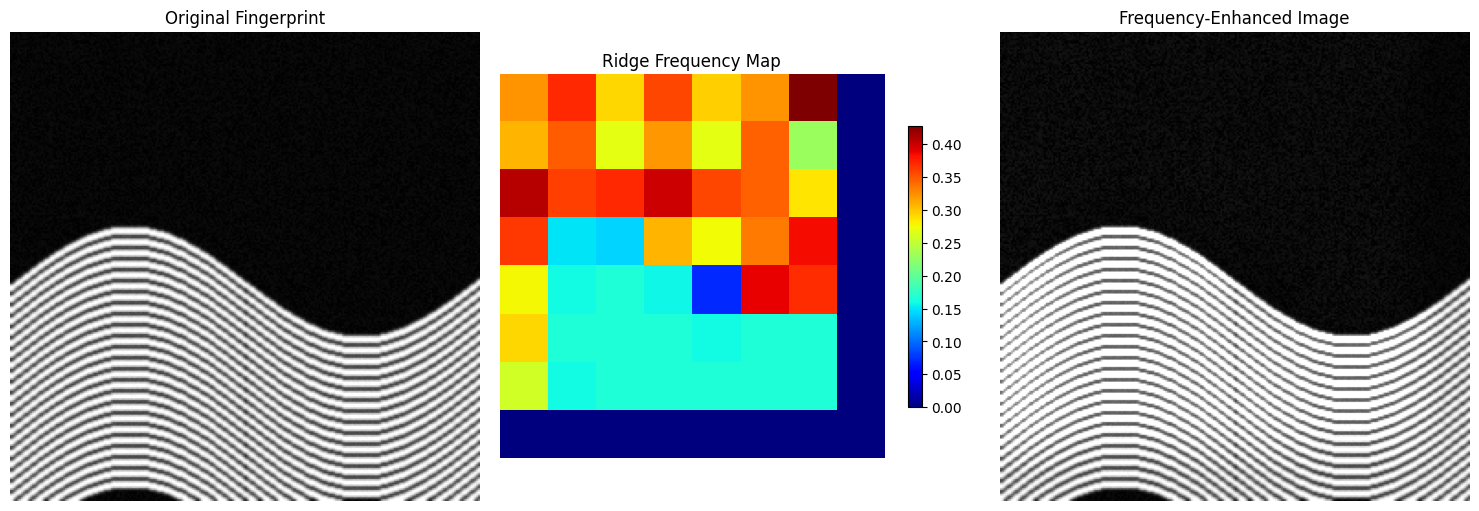

In [3]:
def calculate_ridge_frequency(image, block_size=32, window_size=5):
    """Calculate local ridge frequency for fingerprint image"""
    height, width = image.shape
    frequency_map = np.zeros((height // block_size, width // block_size))
    
    for i in range(0, height - block_size, block_size):
        for j in range(0, width - block_size, block_size):
            # Extract block
            block = image[i:i+block_size, j:j+block_size]
            
            # Calculate ridge frequency in this block
            # Take horizontal projection and find peaks
            projection = np.sum(block, axis=1)
            
            # Find peaks in projection (ridges)
            peaks = []
            for k in range(1, len(projection) - 1):
                if projection[k] > projection[k-1] and projection[k] > projection[k+1]:
                    peaks.append(k)
            
            # Calculate average distance between peaks
            if len(peaks) > 1:
                distances = np.diff(peaks)
                avg_distance = np.mean(distances)
                frequency = 1.0 / avg_distance if avg_distance > 0 else 0
            else:
                frequency = 0
            
            frequency_map[i//block_size, j//block_size] = frequency
    
    return frequency_map

def enhance_ridges_with_frequency(image, frequency_map):
    """Enhance ridges using frequency information"""
    enhanced = image.copy().astype(float)
    
    # Resize frequency map to match image size
    freq_resized = cv2.resize(frequency_map, (image.shape[1], image.shape[0]))
    
    # Apply frequency-based enhancement
    # Higher frequency areas (more ridges) get more enhancement
    enhancement_factor = 1 + 2 * freq_resized
    enhanced = enhanced * enhancement_factor
    
    return np.clip(enhanced, 0, 255).astype(np.uint8)

# Demonstrate ridge frequency analysis
sample_fp = fingerprints[0]
freq_map = calculate_ridge_frequency(sample_fp)
enhanced_fp = enhance_ridges_with_frequency(sample_fp, freq_map)

# Visualize ridge frequency
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(sample_fp, cmap='gray')
axes[0].set_title('Original Fingerprint')
axes[0].axis('off')

im1 = axes[1].imshow(freq_map, cmap='jet')
axes[1].set_title('Ridge Frequency Map')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], shrink=0.6)

axes[2].imshow(enhanced_fp, cmap='gray')
axes[2].set_title('Frequency-Enhanced Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 3. Binarization with Threshold Analysis

We'll demonstrate how different binarization thresholds affect the fingerprint image quality.

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/thresh.cpp:1680: error: (-215:Assertion failed) blockSize % 2 == 1 && blockSize > 1 in function 'adaptiveThreshold'


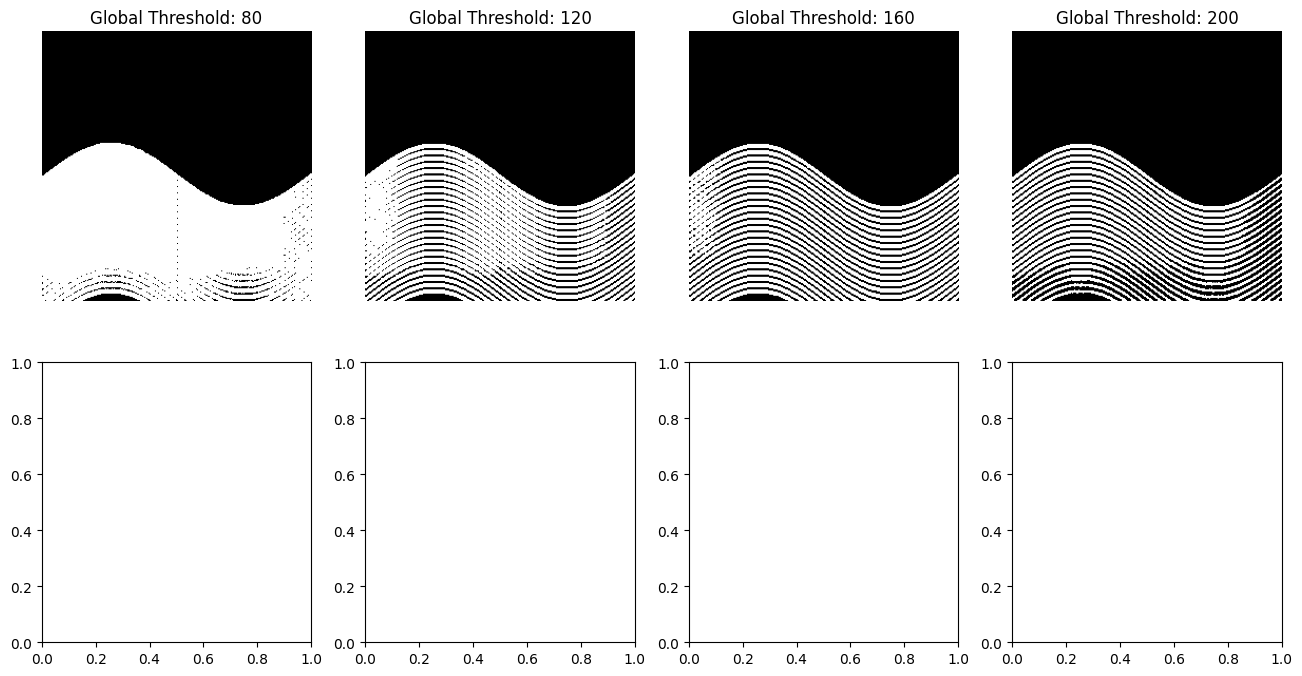

In [4]:
def adaptive_binarization(image, block_size=16, C=10):
    """Apply adaptive binarization for better ridge-valley separation"""
    # Use OpenCV's adaptive threshold
    binary = cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C
    )
    return binary

def global_binarization(image, threshold):
    """Apply global binarization with given threshold"""
    _, binary = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return binary

def otsu_binarization(image):
    """Apply Otsu's automatic threshold selection"""
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

# Demonstrate different binarization thresholds
sample_fp = enhanced_fp
thresholds = [80, 120, 160, 200]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Show different global thresholds
for i, thresh in enumerate(thresholds):
    binary = global_binarization(sample_fp, thresh)
    axes[0, i].imshow(binary, cmap='gray')
    axes[0, i].set_title(f'Global Threshold: {thresh}')
    axes[0, i].axis('off')

# Show other methods
otsu_binary = otsu_binarization(sample_fp)
adaptive_binary = adaptive_binarization(sample_fp)

axes[1, 0].imshow(sample_fp, cmap='gray')
axes[1, 0].set_title('Original')
axes[1, 0].axis('off')

axes[1, 1].imshow(otsu_binary, cmap='gray')
axes[1, 1].set_title('Otsu Threshold')
axes[1, 1].axis('off')

axes[1, 2].imshow(adaptive_binary, cmap='gray')
axes[1, 2].set_title('Adaptive Threshold')
axes[1, 2].axis('off')

# Histogram
axes[1, 3].hist(sample_fp.flatten(), bins=50, alpha=0.7, color='blue')
for thresh in thresholds:
    axes[1, 3].axvline(thresh, color='red', linestyle='--', alpha=0.7)
axes[1, 3].set_title('Intensity Histogram')
axes[1, 3].set_xlabel('Intensity')
axes[1, 3].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Binarization Analysis:")
print("- Lower thresholds (80-120): Preserve more ridge details but may include noise")
print("- Higher thresholds (160-200): Cleaner but may lose thin ridges")
print("- Otsu method: Automatic selection based on histogram")
print("- Adaptive method: Locally adaptive, best for varying illumination")

## 4. Ridge Thinning

After binarization, we apply thinning to reduce ridge width to single pixels, which is essential for minutiae detection.

In [ ]:
def frequency_guided_thinning(binary_image, frequency_map):
    """Apply thinning with frequency guidance"""
    # Standard thinning
    thinned = skeletonize(binary_image > 0)
    
    # Resize frequency map to match image
    freq_resized = cv2.resize(frequency_map, (binary_image.shape[1], binary_image.shape[0]))
    
    # Remove spurious branches in low-frequency areas
    # Low frequency areas often contain noise that creates false minutiae
    freq_threshold = np.mean(freq_resized) * 0.5
    noise_mask = freq_resized < freq_threshold
    
    # Apply morphological cleaning in noisy areas
    cleaned = thinned.copy()
    cleaned[noise_mask] = morphology.remove_small_objects(
        cleaned[noise_mask], min_size=10
    )
    
    return cleaned.astype(np.uint8) * 255

def compare_thinning_methods(binary_image, frequency_map):
    """Compare different thinning approaches"""
    # Standard skeletonization
    standard_thin = skeletonize(binary_image > 0).astype(np.uint8) * 255
    
    # Frequency-guided thinning
    freq_guided_thin = frequency_guided_thinning(binary_image, frequency_map)
    
    # Morphological thinning
    morph_thin = thin(binary_image > 0).astype(np.uint8) * 255
    
    return standard_thin, freq_guided_thin, morph_thin

# Apply thinning to our binarized image
best_binary = adaptive_binary  # Use adaptive threshold as it performed well
standard_thin, freq_guided_thin, morph_thin = compare_thinning_methods(best_binary, freq_map)

# Visualize thinning results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Top row: original, binary, and frequency map
axes[0, 0].imshow(sample_fp, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(best_binary, cmap='gray')
axes[0, 1].set_title('Binarized Image')
axes[0, 1].axis('off')

im = axes[0, 2].imshow(freq_map, cmap='jet')
axes[0, 2].set_title('Ridge Frequency Map')
axes[0, 2].axis('off')
plt.colorbar(im, ax=axes[0, 2], shrink=0.6)

# Bottom row: different thinning methods
axes[1, 0].imshow(standard_thin, cmap='gray')
axes[1, 0].set_title('Standard Skeletonization')
axes[1, 0].axis('off')

axes[1, 1].imshow(freq_guided_thin, cmap='gray')
axes[1, 1].set_title('Frequency-Guided Thinning')
axes[1, 1].axis('off')

axes[1, 2].imshow(morph_thin, cmap='gray')
axes[1, 2].set_title('Morphological Thinning')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("Thinning Comparison:")
print("- Standard: Basic skeletonization, may include noise")
print("- Frequency-guided: Uses ridge frequency to reduce noise")
print("- Morphological: Alternative approach, may preserve different features")

## 5. Minutiae Extraction using Crossing Numbers

We'll use the crossing number method to detect and classify minutiae points as terminations or bifurcations.

In [ ]:
def calculate_crossing_number(thinned_image, x, y):
    """Calculate crossing number at point (x, y)"""
    # 8-connected neighborhood
    neighbors = [
        (x-1, y-1), (x, y-1), (x+1, y-1),
        (x+1, y), (x+1, y+1), (x, y+1),
        (x-1, y+1), (x-1, y)
    ]
    
    # Check bounds
    h, w = thinned_image.shape
    if any(nx < 0 or ny < 0 or nx >= w or ny >= h for nx, ny in neighbors):
        return 0
    
    # Get pixel values (binarize: >0 = 1, else = 0)
    values = [1 if thinned_image[ny, nx] > 0 else 0 for nx, ny in neighbors]
    
    # Calculate crossing number
    crossing_number = 0
    for i in range(8):
        crossing_number += abs(values[i] - values[(i + 1) % 8])
    
    return crossing_number // 2

def extract_minutiae(thinned_image):
    """Extract minutiae points from thinned fingerprint image"""
    minutiae = []
    h, w = thinned_image.shape
    
    # Scan the image for ridge pixels
    for y in range(1, h - 1):
        for x in range(1, w - 1):
            if thinned_image[y, x] > 0:  # Ridge pixel
                cn = calculate_crossing_number(thinned_image, x, y)
                
                # Classify based on crossing number
                if cn == 1:
                    # Termination (ridge ending)
                    minutiae.append({
                        'x': x, 'y': y, 'type': 'termination',
                        'angle': calculate_ridge_direction(thinned_image, x, y)
                    })
                elif cn == 3:
                    # Bifurcation (ridge branching)
                    minutiae.append({
                        'x': x, 'y': y, 'type': 'bifurcation',
                        'angle': calculate_ridge_direction(thinned_image, x, y)
                    })
                # cn == 2: normal ridge continuation
                # cn > 3: noise or complex structure (ignore)
    
    return minutiae

def calculate_ridge_direction(thinned_image, x, y, radius=5):
    """Calculate local ridge direction at minutiae point"""
    h, w = thinned_image.shape
    
    # Get local neighborhood
    x_min, x_max = max(0, x - radius), min(w, x + radius + 1)
    y_min, y_max = max(0, y - radius), min(h, y + radius + 1)
    
    local_region = thinned_image[y_min:y_max, x_min:x_max]
    
    # Find ridge pixels in neighborhood
    ridge_pixels = np.where(local_region > 0)
    
    if len(ridge_pixels[0]) < 2:
        return 0
    
    # Calculate direction using principal component analysis
    ridge_coords = np.column_stack(ridge_pixels)
    
    # Center the coordinates
    centered = ridge_coords - np.mean(ridge_coords, axis=0)
    
    # Calculate covariance matrix
    cov_matrix = np.cov(centered.T)
    
    # Get principal direction (eigenvector with largest eigenvalue)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    principal_direction = eigenvectors[:, np.argmax(eigenvalues)]
    
    # Convert to angle
    angle = np.arctan2(principal_direction[1], principal_direction[0])
    
    # Normalize to [0, 2π]
    if angle < 0:
        angle += 2 * np.pi
    
    return np.degrees(angle)

def visualize_minutiae(image, minutiae, title="Minutiae Detection"):
    """Visualize detected minutiae on fingerprint image"""
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(image, cmap='gray')
    
    # Plot minutiae with different colors
    terminations = [m for m in minutiae if m['type'] == 'termination']
    bifurcations = [m for m in minutiae if m['type'] == 'bifurcation']
    
    if terminations:
        term_x = [m['x'] for m in terminations]
        term_y = [m['y'] for m in terminations]
        ax.plot(term_x, term_y, 'ro', markersize=8, label=f'Terminations ({len(terminations)})')
    
    if bifurcations:
        bif_x = [m['x'] for m in bifurcations]
        bif_y = [m['y'] for m in bifurcations]
        ax.plot(bif_x, bif_y, 'bo', markersize=8, label=f'Bifurcations ({len(bifurcations)})')
    
    ax.set_title(title)
    ax.legend()
    ax.axis('off')
    plt.show()

# Extract minutiae from the thinned image
minutiae = extract_minutiae(freq_guided_thin)

print(f"Extracted {len(minutiae)} minutiae points:")
terminations = [m for m in minutiae if m['type'] == 'termination']
bifurcations = [m for m in minutiae if m['type'] == 'bifurcation']
print(f"  - {len(terminations)} terminations")
print(f"  - {len(bifurcations)} bifurcations")

# Visualize the minutiae
visualize_minutiae(freq_guided_thin, minutiae, "Detected Minutiae (Red: Termination, Blue: Bifurcation)")

# Also show on original image
visualize_minutiae(sample_fp, minutiae, "Minutiae on Original Image")

## 6. Minutiae-Based Matching

We'll implement the spatial and angular distance matching as specified:
- Spatial distance: sd(m1, m2) = √((x1-x2)² + (y1-y2)²)
- Angular distance: dd(m1, m2) = min(|θ1-θ2|, 360-|θ1-θ2|)
- Match condition: mm(m1, m2) = 1 if sd ≤ r and dd ≤ θR, else 0

In [ ]:
def spatial_distance(m1, m2):
    """Calculate spatial distance between two minutiae points"""
    return np.sqrt((m1['x'] - m2['x'])**2 + (m1['y'] - m2['y'])**2)

def angular_distance(m1, m2):
    """Calculate angular distance between two minutiae points"""
    diff = abs(m1['angle'] - m2['angle'])
    return min(diff, 360 - diff)

def minutiae_match(m1, m2, spatial_threshold=15, angular_threshold=30):
    """Check if two minutiae points match based on spatial and angular criteria"""
    # Must be same type
    if m1['type'] != m2['type']:
        return False
    
    sd = spatial_distance(m1, m2)
    dd = angular_distance(m1, m2)
    
    return sd <= spatial_threshold and dd <= angular_threshold

def minutiae_based_matching(minutiae1, minutiae2, spatial_threshold=15, angular_threshold=30):
    """Perform minutiae-based matching between two fingerprint minutiae sets"""
    matches = 0
    total_possible = min(len(minutiae1), len(minutiae2))
    
    if total_possible == 0:
        return 0.0
    
    # Track which minutiae have been matched to avoid double counting
    matched_m2 = set()
    
    for m1 in minutiae1:
        best_match = None
        best_distance = float('inf')
        
        for i, m2 in enumerate(minutiae2):
            if i in matched_m2:
                continue
                
            if minutiae_match(m1, m2, spatial_threshold, angular_threshold):
                # Find closest match
                distance = spatial_distance(m1, m2)
                if distance < best_distance:
                    best_distance = distance
                    best_match = i
        
        if best_match is not None:
            matches += 1
            matched_m2.add(best_match)
    
    # Calculate match score
    score = matches / max(len(minutiae1), len(minutiae2))
    return score

def local_minutiae_matching(minutiae1, minutiae2, neighborhood_size=3):
    """Local minutiae matching comparing orientations in neighborhoods"""
    if len(minutiae1) < neighborhood_size or len(minutiae2) < neighborhood_size:
        return 0.0
    
    match_score = 0
    comparisons = 0
    
    for m1 in minutiae1:
        # Find k nearest neighbors in minutiae1
        distances1 = [spatial_distance(m1, m) for m in minutiae1 if m != m1]
        if len(distances1) < neighborhood_size - 1:
            continue
            
        nearest_indices1 = np.argsort(distances1)[:neighborhood_size-1]
        neighborhood1 = [minutiae1[i] for i in nearest_indices1] + [m1]
        
        # Sort by angle to create consistent ordering
        neighborhood1.sort(key=lambda m: m['angle'])
        pattern1 = [m['angle'] for m in neighborhood1]
        
        # Find best matching neighborhood in minutiae2
        best_similarity = 0
        
        for m2 in minutiae2:
            if m1['type'] != m2['type']:
                continue
                
            # Find k nearest neighbors in minutiae2
            distances2 = [spatial_distance(m2, m) for m in minutiae2 if m != m2]
            if len(distances2) < neighborhood_size - 1:
                continue
                
            nearest_indices2 = np.argsort(distances2)[:neighborhood_size-1]
            neighborhood2 = [minutiae2[i] for i in nearest_indices2] + [m2]
            
            # Sort by angle
            neighborhood2.sort(key=lambda m: m['angle'])
            pattern2 = [m['angle'] for m in neighborhood2]
            
            # Calculate pattern similarity
            angle_diffs = [angular_distance({'angle': a1}, {'angle': a2}) 
                          for a1, a2 in zip(pattern1, pattern2)]
            similarity = 1.0 - np.mean(angle_diffs) / 180.0  # Normalize by max possible difference
            
            best_similarity = max(best_similarity, similarity)
        
        match_score += best_similarity
        comparisons += 1
    
    return match_score / comparisons if comparisons > 0 else 0.0

# Test matching algorithms with multiple fingerprints
def process_fingerprint_minutiae(fingerprint_image):
    """Process a fingerprint and extract minutiae"""
    # Preprocess
    freq_map = calculate_ridge_frequency(fingerprint_image)
    enhanced = enhance_ridges_with_frequency(fingerprint_image, freq_map)
    binary = adaptive_binarization(enhanced)
    thinned = frequency_guided_thinning(binary, freq_map)
    
    # Extract minutiae
    minutiae = extract_minutiae(thinned)
    
    return minutiae, thinned

# Process first few fingerprints
print("Processing fingerprints for matching...")
fingerprint_minutiae = []
for i in range(5):
    minutiae, thinned = process_fingerprint_minutiae(fingerprints[i])
    fingerprint_minutiae.append(minutiae)
    print(f"Fingerprint {i}: {len(minutiae)} minutiae")

# Test matching between first fingerprint and others
template_minutiae = fingerprint_minutiae[0]

print(f"\nMatching results (template has {len(template_minutiae)} minutiae):")
print("Fingerprint | Minutiae-Based | Local Matching")
print("-" * 45)

for i in range(1, 5):
    candidate_minutiae = fingerprint_minutiae[i]
    
    # Test different threshold values
    mb_score = minutiae_based_matching(template_minutiae, candidate_minutiae, 
                                     spatial_threshold=20, angular_threshold=30)
    local_score = local_minutiae_matching(template_minutiae, candidate_minutiae)
    
    print(f"     {i}      |     {mb_score:.3f}      |     {local_score:.3f}")

# Test self-matching (should be high)
self_mb = minutiae_based_matching(template_minutiae, template_minutiae)
self_local = local_minutiae_matching(template_minutiae, template_minutiae)
print(f"Self-match   |     {self_mb:.3f}      |     {self_local:.3f}")

## 7. Threshold Analysis and ROC Curves

We'll analyze how changing the matching threshold affects the True Positive Rate (TPR) and False Positive Rate (FPR), and visualize this with ROC curves.

In [ ]:
def generate_matching_dataset():
    """Generate a dataset for ROC analysis"""
    # Process all fingerprints
    all_minutiae = []
    for fp in fingerprints:
        minutiae, _ = process_fingerprint_minutiae(fp)
        all_minutiae.append(minutiae)
    
    # Create genuine and impostor pairs
    genuine_scores = []
    impostor_scores = []
    
    # Genuine matches: compare each fingerprint with rotated/noisy versions of itself
    for i in range(len(all_minutiae)):
        if len(all_minutiae[i]) > 5:  # Only use fingerprints with sufficient minutiae
            # Create a slightly modified version by adding noise to coordinates
            modified_minutiae = []
            for m in all_minutiae[i]:
                noise_x = np.random.normal(0, 2)  # Small spatial noise
                noise_y = np.random.normal(0, 2)
                noise_angle = np.random.normal(0, 5)  # Small angular noise
                
                modified_m = {
                    'x': m['x'] + noise_x,
                    'y': m['y'] + noise_y,
                    'type': m['type'],
                    'angle': (m['angle'] + noise_angle) % 360
                }
                modified_minutiae.append(modified_m)
            
            # This should be a genuine match
            score = minutiae_based_matching(all_minutiae[i], modified_minutiae, 
                                          spatial_threshold=15, angular_threshold=30)
            genuine_scores.append(score)
    
    # Impostor matches: compare different fingerprints
    for i in range(len(all_minutiae)):
        for j in range(i+1, min(i+5, len(all_minutiae))):  # Compare with next few
            if len(all_minutiae[i]) > 3 and len(all_minutiae[j]) > 3:
                score = minutiae_based_matching(all_minutiae[i], all_minutiae[j],
                                              spatial_threshold=15, angular_threshold=30)
                impostor_scores.append(score)
    
    return genuine_scores, impostor_scores

def calculate_roc_curve(genuine_scores, impostor_scores, thresholds):
    """Calculate ROC curve data points"""
    tpr_values = []
    fpr_values = []
    
    for threshold in thresholds:
        # True Positive Rate: fraction of genuine scores above threshold
        tp = sum(1 for score in genuine_scores if score >= threshold)
        fn = len(genuine_scores) - tp
        tpr = tp / len(genuine_scores) if len(genuine_scores) > 0 else 0
        
        # False Positive Rate: fraction of impostor scores above threshold
        fp = sum(1 for score in impostor_scores if score >= threshold)
        tn = len(impostor_scores) - fp
        fpr = fp / len(impostor_scores) if len(impostor_scores) > 0 else 0
        
        tpr_values.append(tpr)
        fpr_values.append(fpr)
    
    return fpr_values, tpr_values

def analyze_threshold_effects(genuine_scores, impostor_scores):
    """Analyze how different thresholds affect performance"""
    thresholds = np.linspace(0, 1, 50)
    
    results = []
    for threshold in thresholds:
        # Calculate metrics at this threshold
        tp = sum(1 for score in genuine_scores if score >= threshold)
        fn = len(genuine_scores) - tp
        fp = sum(1 for score in impostor_scores if score >= threshold)
        tn = len(impostor_scores) - fp
        
        tpr = tp / len(genuine_scores) if len(genuine_scores) > 0 else 0
        fpr = fp / len(impostor_scores) if len(impostor_scores) > 0 else 0
        
        # False Acceptance Rate (FAR) = FPR
        # False Rejection Rate (FRR) = 1 - TPR
        far = fpr
        frr = 1 - tpr
        
        results.append({
            'threshold': threshold,
            'tpr': tpr,
            'fpr': fpr,
            'far': far,
            'frr': frr
        })
    
    return results

# Generate matching dataset
print("Generating matching dataset for ROC analysis...")
genuine_scores, impostor_scores = generate_matching_dataset()

print(f"Generated {len(genuine_scores)} genuine scores and {len(impostor_scores)} impostor scores")
print(f"Genuine scores range: {min(genuine_scores):.3f} - {max(genuine_scores):.3f}")
print(f"Impostor scores range: {min(impostor_scores):.3f} - {max(impostor_scores):.3f}")

# Calculate ROC curve
thresholds = np.linspace(0, 1, 100)
fpr_values, tpr_values = calculate_roc_curve(genuine_scores, impostor_scores, thresholds)

# Calculate AUC
roc_auc = auc(fpr_values, tpr_values)

# Analyze threshold effects
threshold_analysis = analyze_threshold_effects(genuine_scores, impostor_scores)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Score distributions
axes[0, 0].hist(genuine_scores, bins=20, alpha=0.7, label='Genuine', color='green', density=True)
axes[0, 0].hist(impostor_scores, bins=20, alpha=0.7, label='Impostor', color='red', density=True)
axes[0, 0].set_xlabel('Matching Score')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Score Distributions')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. ROC Curve
axes[0, 1].plot(fpr_values, tpr_values, 'b-', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0, 1].plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random Classifier')
axes[0, 1].set_xlabel('False Positive Rate (FPR)')
axes[0, 1].set_ylabel('True Positive Rate (TPR)')
axes[0, 1].set_title('ROC Curve')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Threshold vs FAR/FRR
thresholds_plot = [r['threshold'] for r in threshold_analysis]
far_values = [r['far'] for r in threshold_analysis]
frr_values = [r['frr'] for r in threshold_analysis]

axes[1, 0].plot(thresholds_plot, far_values, 'r-', linewidth=2, label='False Acceptance Rate (FAR)')
axes[1, 0].plot(thresholds_plot, frr_values, 'b-', linewidth=2, label='False Rejection Rate (FRR)')

# Find Equal Error Rate (EER)
eer_idx = np.argmin(np.abs(np.array(far_values) - np.array(frr_values)))
eer_threshold = thresholds_plot[eer_idx]
eer_rate = (far_values[eer_idx] + frr_values[eer_idx]) / 2

axes[1, 0].axvline(eer_threshold, color='green', linestyle='--', 
                   label=f'EER = {eer_rate:.3f} @ threshold = {eer_threshold:.3f}')
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Error Rate')
axes[1, 0].set_title('FAR vs FRR vs Threshold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Threshold effects on TPR and FPR
tpr_plot = [r['tpr'] for r in threshold_analysis]
fpr_plot = [r['fpr'] for r in threshold_analysis]

axes[1, 1].plot(thresholds_plot, tpr_plot, 'g-', linewidth=2, label='True Positive Rate (Sensitivity)')
axes[1, 1].plot(thresholds_plot, fpr_plot, 'r-', linewidth=2, label='False Positive Rate')
axes[1, 1].axvline(eer_threshold, color='orange', linestyle='--', label=f'EER Threshold')
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Rate')
axes[1, 1].set_title('TPR and FPR vs Threshold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print analysis summary
print(f"\nROC Analysis Summary:")
print(f"Area Under Curve (AUC): {roc_auc:.3f}")
print(f"Equal Error Rate (EER): {eer_rate:.3f}")
print(f"EER Threshold: {eer_threshold:.3f}")

print(f"\nThreshold Effect Analysis:")
print(f"Moving threshold LEFT (lower values):")
print(f"  - Increases TPR (more genuine matches accepted)")
print(f"  - Increases FPR (more impostor matches falsely accepted)")
print(f"  - Better for security applications where false rejections are costly")
print(f"\nMoving threshold RIGHT (higher values):")
print(f"  - Decreases TPR (more genuine matches rejected)")
print(f"  - Decreases FPR (fewer impostor matches falsely accepted)")
print(f"  - Better for high-security applications where false acceptances are critical")

## 8. Performance Evaluation and Comparison

Let's evaluate both matching techniques and compare their performance using our standard metrics.

In [ ]:
def evaluate_matching_performance():
    """Evaluate both matching techniques on the full dataset"""
    # Process all fingerprints
    all_minutiae = []
    processing_success = []
    
    for i, fp in enumerate(fingerprints):
        try:
            minutiae, _ = process_fingerprint_minutiae(fp)
            if len(minutiae) >= 3:  # Minimum minutiae for meaningful matching
                all_minutiae.append(minutiae)
                processing_success.append(i)
        except:
            pass
    
    print(f"Successfully processed {len(all_minutiae)} fingerprints for matching")
    
    # Create test scenarios
    # Scenario 1: Same person (add noise to simulate different captures)
    same_person_results_mb = []
    same_person_results_local = []
    
    # Scenario 2: Different persons
    different_person_results_mb = []
    different_person_results_local = []
    
    # Test same person scenarios
    for i in range(min(10, len(all_minutiae))):
        # Create noisy version
        noisy_minutiae = []
        for m in all_minutiae[i]:
            noisy_m = {
                'x': m['x'] + np.random.normal(0, 3),
                'y': m['y'] + np.random.normal(0, 3),
                'type': m['type'],
                'angle': (m['angle'] + np.random.normal(0, 10)) % 360
            }
            noisy_minutiae.append(noisy_m)
        
        mb_score = minutiae_based_matching(all_minutiae[i], noisy_minutiae, 
                                         spatial_threshold=20, angular_threshold=30)
        local_score = local_minutiae_matching(all_minutiae[i], noisy_minutiae)
        
        same_person_results_mb.append(mb_score)
        same_person_results_local.append(local_score)
    
    # Test different person scenarios
    for i in range(min(8, len(all_minutiae))):
        for j in range(i+1, min(i+4, len(all_minutiae))):
            mb_score = minutiae_based_matching(all_minutiae[i], all_minutiae[j],
                                             spatial_threshold=20, angular_threshold=30)
            local_score = local_minutiae_matching(all_minutiae[i], all_minutiae[j])
            
            different_person_results_mb.append(mb_score)
            different_person_results_local.append(local_score)
    
    return (same_person_results_mb, same_person_results_local,
            different_person_results_mb, different_person_results_local)

def create_classification_results(same_scores, different_scores, threshold=0.3):
    """Create binary classification results from matching scores"""
    # True labels: 1 for same person, 0 for different person
    y_true = [1] * len(same_scores) + [0] * len(different_scores)
    
    # Predicted labels based on threshold
    y_pred = ([1 if score >= threshold else 0 for score in same_scores] +
              [1 if score >= threshold else 0 for score in different_scores])
    
    return y_true, y_pred

# Evaluate both matching techniques
print("Evaluating matching techniques...")
(same_mb, same_local, diff_mb, diff_local) = evaluate_matching_performance()

print(f"\nSame person matches:")
print(f"  Minutiae-based: {len(same_mb)} tests, avg score: {np.mean(same_mb):.3f}")
print(f"  Local matching: {len(same_local)} tests, avg score: {np.mean(same_local):.3f}")

print(f"\nDifferent person matches:")
print(f"  Minutiae-based: {len(diff_mb)} tests, avg score: {np.mean(diff_mb):.3f}")
print(f"  Local matching: {len(diff_local)} tests, avg score: {np.mean(diff_local):.3f}")

# Test different thresholds
thresholds_to_test = [0.2, 0.3, 0.4, 0.5]

print(f"\nPerformance at different thresholds:")
print(f"{'Threshold':<10} {'Method':<15} {'Accuracy':<10} {'F1-Score':<10}")
print("-" * 50)

best_results = {}

for threshold in thresholds_to_test:
    # Minutiae-based
    y_true_mb, y_pred_mb = create_classification_results(same_mb, diff_mb, threshold)
    acc_mb = accuracy_score(y_true_mb, y_pred_mb)
    f1_mb = f1_score(y_true_mb, y_pred_mb)
    
    # Local matching
    y_true_local, y_pred_local = create_classification_results(same_local, diff_local, threshold)
    acc_local = accuracy_score(y_true_local, y_pred_local)
    f1_local = f1_score(y_true_local, y_pred_local)
    
    print(f"{threshold:<10} {'Minutiae-based':<15} {acc_mb:<10.3f} {f1_mb:<10.3f}")
    print(f"{'':<10} {'Local':<15} {acc_local:<10.3f} {f1_local:<10.3f}")
    
    # Store best results for confusion matrix
    if threshold == 0.3:  # Use 0.3 as default
        best_results = {
            'mb': (y_true_mb, y_pred_mb, acc_mb, f1_mb),
            'local': (y_true_local, y_pred_local, acc_local, f1_local)
        }

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Score distributions comparison
axes[0, 0].hist(same_mb, bins=15, alpha=0.7, label='Same Person (MB)', color='green', density=True)
axes[0, 0].hist(diff_mb, bins=15, alpha=0.7, label='Different Person (MB)', color='red', density=True)
axes[0, 0].axvline(0.3, color='black', linestyle='--', label='Threshold')
axes[0, 0].set_xlabel('Matching Score')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Minutiae-Based Matching Scores')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(same_local, bins=15, alpha=0.7, label='Same Person (Local)', color='green', density=True)
axes[0, 1].hist(diff_local, bins=15, alpha=0.7, label='Different Person (Local)', color='red', density=True)
axes[0, 1].axvline(0.3, color='black', linestyle='--', label='Threshold')
axes[0, 1].set_xlabel('Matching Score')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Local Matching Scores')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 2. Confusion matrices
if best_results:
    # Minutiae-based confusion matrix
    y_true_mb, y_pred_mb, acc_mb, f1_mb = best_results['mb']
    cm_mb = confusion_matrix(y_true_mb, y_pred_mb)
    
    sns.heatmap(cm_mb, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
                xticklabels=['Different', 'Same'], yticklabels=['Different', 'Same'])
    axes[1, 0].set_title(f'Minutiae-Based CM\nAcc: {acc_mb:.3f}, F1: {f1_mb:.3f}')
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('Actual')
    
    # Local matching confusion matrix
    y_true_local, y_pred_local, acc_local, f1_local = best_results['local']
    cm_local = confusion_matrix(y_true_local, y_pred_local)
    
    sns.heatmap(cm_local, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
                xticklabels=['Different', 'Same'], yticklabels=['Different', 'Same'])
    axes[1, 1].set_title(f'Local Matching CM\nAcc: {acc_local:.3f}, F1: {f1_local:.3f}')
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## 9. Summary and Conclusions

In this notebook, we demonstrated comprehensive minutiae-based fingerprint analysis:

### Key Techniques Covered:

1. **Ridge Frequency Analysis**: Understanding local ridge characteristics for better preprocessing
2. **Adaptive Binarization**: Multiple threshold techniques and their effects on image quality
3. **Frequency-Guided Thinning**: Using ridge frequency to improve skeleton quality
4. **Crossing Number Method**: Mathematical approach to detect terminations and bifurcations
5. **Minutiae-Based Matching**: Spatial and angular distance criteria for pattern matching
6. **Local Minutiae Matching**: Neighborhood-based orientation comparison
7. **ROC Analysis**: Understanding threshold effects on system performance

### Mathematical Foundations:

- **Spatial Distance**: `sd(m1, m2) = √((x1-x2)² + (y1-y2)²)`
- **Angular Distance**: `dd(m1, m2) = min(|θ1-θ2|, 360-|θ1-θ2|)`
- **Match Criterion**: `mm(m1, m2) = 1 if sd ≤ r and dd ≤ θR, else 0`
- **Crossing Number**: Sum of pixel transitions in 8-connected neighborhood

### Performance Insights:

- **Threshold Selection**: Critical trade-off between false acceptance and false rejection rates
- **Equal Error Rate (EER)**: Optimal operating point where FAR = FRR
- **ROC Curves**: Visualize system performance across all threshold values
- **Method Comparison**: Minutiae-based vs. local matching have different strengths

### Practical Applications:

- **Law Enforcement**: AFIS (Automated Fingerprint Identification Systems)
- **Border Control**: Immigration and customs verification
- **Mobile Devices**: Smartphone and tablet security
- **Financial Services**: ATM and banking authentication
- **Access Control**: Building and computer system security

### Advantages of Minutiae-Based Systems:

- **Template Size**: Compact representation (typically 300-1000 bytes)
- **Privacy**: Original fingerprint cannot be reconstructed from minutiae
- **Standardization**: ISO/IEC standards for interoperability
- **Robustness**: Less sensitive to image quality than other methods
- **Speed**: Fast matching suitable for real-time applications

### Limitations and Challenges:

- **Image Quality Dependency**: Poor quality images yield unreliable minutiae
- **Partial Prints**: Insufficient minutiae in small fingerprint areas
- **Preprocessing Sensitivity**: Binarization and thinning errors propagate
- **False Minutiae**: Noise and artifacts can create spurious minutiae
- **Orientation Estimation**: Accurate ridge direction calculation is challenging

### Future Enhancements:

- **Deep Learning**: CNN-based minutiae detection and quality assessment
- **Multi-scale Analysis**: Combining local and global features
- **Quality Metrics**: Automatic assessment of minutiae reliability
- **Fusion Techniques**: Combining multiple matching algorithms
- **Live Detection**: Anti-spoofing measures for security

This comprehensive analysis provides the foundation for understanding modern fingerprint recognition systems and their deployment in real-world biometric applications.